# E-commerce Product recommendation System

## Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds 

from sklearn.neighbors import NearestNeighbors

## Importing Dataset

In [2]:
#Import the data set
df = pd.read_csv('ratings_Beauty.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

Check for 
- shape 
- datatype
- missing values


Finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

### Shape

In [3]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  2023071
No of columns =  3


### Datatypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023071 entries, 0 to 2023070
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   prod_id  object
 2   rating   object
dtypes: object(3)
memory usage: 46.3+ MB


### Missing value analysis

In [5]:
# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

### Summary

In [6]:
# Summary statistics of 'rating' variable
df['rating'].describe()

count     2023071.0
unique         11.0
top             5.0
freq      1165521.0
Name: rating, dtype: float64

### Rating distribution

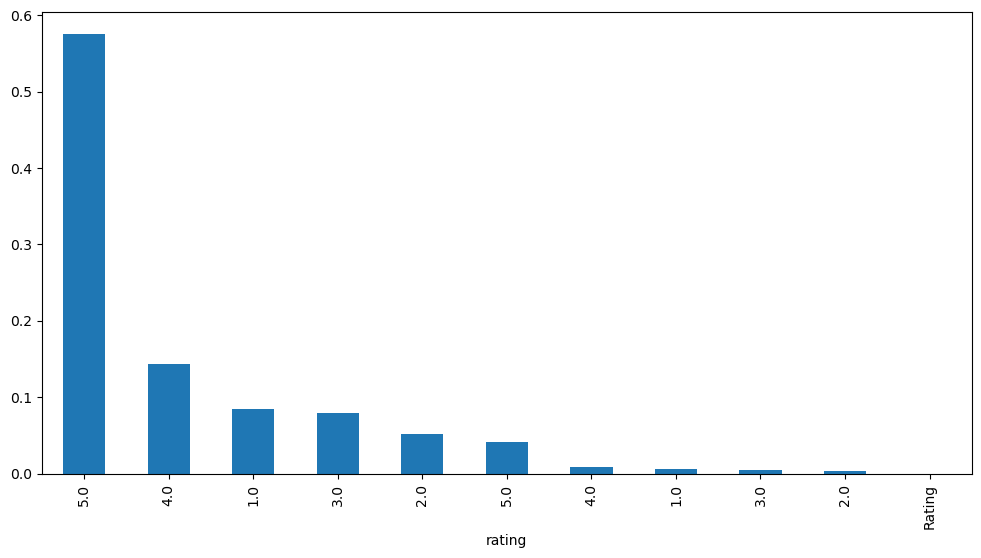

In [7]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [8]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  1210272
Number of unique ITEMS in Raw data =  249275


### Users with most no of rating

In [9]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
ALQGOMOY1F5X9     275
AKMEY1BSHSDG7     269
A3R9H6OKZHHRJD    259
A1M04H40ZVGWVG    249
A1RRMZKOMZ2M7J    225
dtype: int64

## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 30 or more ratings) to make the dataset less sparse and easy to work with.

In [10]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 30].index)]
df_final

,user_id,prod_id,rating
6,AKJHHD5VEH7VG,0762451459,5.0
7,A1BG8QW55XHN6U,1304139212,5.0
11,A1BG8QW55XHN6U,130414643X,5.0
20,A1BG8QW55XHN6U,1304174867,5.0
21,A1BG8QW55XHN6U,1304174905,5.0
...,...,...,...
2023027,A3NHUQ33CFH3VM,B00LLPT4HI,5.0
2023036,A1UQBFCERIP7VJ,B00LLPT4HI,5.0
2023039,A35Q0RBM3YNQNF,B00LLPT4HI,5.0
2023043,A3LGT6UZL99IW1,B00LLPT4HI,5.0


In [11]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 58289
Number of unique USERS in the final data =  1136
Number of unique PRODUCTS in the final data =  28614


- **The dataframe df_final has users who have rated 30 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [12]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1136, 28614)
given_num_of_ratings =  58289
possible_num_of_ratings =  32505504
density: 0.18%


prod_id,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
user_id,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103979529MRJY0U56QI4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
final_ratings_matrix = final_ratings_matrix.apply(pd.to_numeric, errors='coerce')
df_final['rating'] = pd.to_numeric(df_final['rating'], errors='coerce')

# Rank Based Recommendation System 

In [14]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
0762451459,5.0,1
B003SWVV8C,5.0,1
B003T16HLS,5.0,1
B003T12MHG,5.0,1
B003T01IAO,5.0,1


In [15]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    
    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values('avg_rating',ascending=False)
    
    return recommendations.index[:n]

## Recommending top 5 products with 50 minimum interactions based on popularity

In [16]:
list(top_n_products(final_rating, 5, 50))

['B00A0J09C0', 'B000E0K7NQ', 'B00AWLB9G6', 'B009YSSLAU', 'B00A0J09G6']

## Recommending top 5 products with 100 minimum interactions based on popularity

In [17]:
list(top_n_products(final_rating, 5, 100))

['B009FKNGGQ']

# Collaborative Filtering based Recommendation System 

## User based collaborative filtering

In [18]:
final_ratings_matrix.head()

prod_id,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
user_id,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103979529MRJY0U56QI4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 58288 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [19]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function to find Similar users and their similarity scores

In [20]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] #Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

#### Finding out top 10 similar users to the user index 3 and their similarity score

In [21]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[173, 191, 233, 25, 973, 1014, 720, 406, 992, 824]

In [22]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.11142077]]),
 array([[0.10595625]]),
 array([[0.09610647]]),
 array([[0.08977601]]),
 array([[0.08327229]]),
 array([[0.07260818]]),
 array([[0.07147487]]),
 array([[0.05930774]]),
 array([[0.05319582]]),
 array([[0.0499904]])]

#### Finding out top 10 similar users to the user index 360 and their similarity score

In [23]:
similar = similar_users(360, final_ratings_matrix)[0][0:10]
similar

[32, 928, 307, 302, 571, 1029, 963, 266, 1002, 418]

In [24]:
#Print the similarity score
similar_users(360,final_ratings_matrix)[1][0:10]

[array([[0.35889815]]),
 array([[0.35385197]]),
 array([[0.3435369]]),
 array([[0.34011848]]),
 array([[0.33320182]]),
 array([[0.3265321]]),
 array([[0.31884715]]),
 array([[0.30722942]]),
 array([[0.30225485]]),
 array([[0.30069394]])]

### Function to recommend products

In [25]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):
    interactions_matrix = interactions_matrix.apply(pd.to_numeric, errors='coerce')
    interactions_matrix = interactions_matrix.fillna(0)  # Replacing NaNs with 0

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [26]:
recommendations(3,5,final_ratings_matrix)

['B008Y9JRQM', 'B003OH07G8', 'B004SSFE8S', 'B003OH2Q80', 'B003VMOGSQ']

#### Recommend 5 products to user index 360 based on similarity based collaborative filtering

In [27]:
recommendations(360,5,final_ratings_matrix)

['B00AE07932', 'B007RTR8T8', 'B007JT7AIK', 'B001ECQ4JE', 'B001JSU67O']

# Model based Collaborative Filtering: Singular Value Decomposition 

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

## CSR matrix

In [28]:
from scipy.sparse import csr_matrix

final_ratings_sparse = csr_matrix(final_ratings_matrix.values)

## SVD

In [29]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [30]:
U.shape

(1136, 50)

In [31]:
sigma.shape

(50, 50)

In [32]:
Vt.shape

(50, 28614)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

## Predicting ratings

In [33]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

## Function to recommend products

In [48]:
def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    print(temp.head)
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


### Recommending top 5 products to user id 121

In [35]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121,final_ratings_sparse,preds_matrix,5)

<bound method NDFrame.head of                       user_ratings  user_predictions
Recommended Products                                
0                              0.0          0.004114
1                              0.0          0.000197
2                              0.0          0.000197
3                              0.0          0.000197
4                              0.0          0.000197
...                            ...               ...
28609                          4.0          0.584880
28610                          0.0          0.000091
28611                          0.0          0.000288
28612                          0.0          0.028853
28613                          0.0          0.001566

[28614 rows x 2 columns]>

Below are the recommended products for user(user_id = 121):

Recommended Products
26430    3.183630
26318    3.172190
27584    3.023467
28460    2.884669
28457    2.523248
Name: user_predictions, dtype: float64


### Recommending top 10 products to user id 100

In [36]:
recommend_items(100,final_ratings_sparse,preds_matrix,10)

<bound method NDFrame.head of                       user_ratings  user_predictions
Recommended Products                                
0                              0.0          0.049676
1                              0.0          0.000645
2                              0.0          0.000645
3                              0.0          0.000645
4                              0.0          0.000645
...                            ...               ...
28609                          0.0          0.019369
28610                          0.0          0.000760
28611                          0.0          0.010149
28612                          0.0          0.046390
28613                          0.0          0.000668

[28614 rows x 2 columns]>

Below are the recommended products for user(user_id = 100):

Recommended Products
19459    1.336344
22248    1.177926
20603    1.028571
21443    0.995042
9374     0.951789
21438    0.851119
1881     0.848476
21439    0.797005
21435    0.789439
23987    

# Recommender Systems using KNN

One common approach to building recommender systems is using **the K-Nearest Neighbors (KNN)** algorithm. KNN is used to find the closest neighbours (either users or items) based on a similarity metric. The recommendations are then made **based on the preferences of these neighbours**.

We normalize the user-item matrix by subtracting the mean rating of each user. This step is important to account for differences in user rating behavior.

In [37]:
# Normalise the matrix by subtracting the mean rating of each user

# Calculate the mean rating for each user
mean_user_rating = np.mean(final_ratings_matrix, axis=1).to_numpy().reshape(-1, 1)

# Subtract the mean rating from each user's ratings
normalized_matrix = final_ratings_matrix.to_numpy() - mean_user_rating

We fit the KNN model using the normalized user-item matrix. The **metric='cosine'** parameter specifies that we use cosine similarity **to measure the similarity between users**.

In [38]:
# Fit the KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(normalized_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [39]:
# Find the k nearest neighbors for a target user (e.g., user index 0)
target_user_index = 121
distances, indices = knn.kneighbors(normalized_matrix[target_user_index].reshape(1, -1), n_neighbors=50)

In [40]:
# Aggregate ratings from the nearest neighbors
neighbors_ratings = final_ratings_matrix.iloc[indices.flatten()]

# Compute the mean rating across the nearest neighbors
predicted_ratings = neighbors_ratings.mean(axis=0)

We identify items that the target user has not rated (i.e., entries with a value of 0). We then recommend the items with the highest predicted ratings.

In [41]:
# Access the row for the target user using `.iloc`
unrated_items = np.where(final_ratings_matrix.iloc[target_user_index] == 0)[0]

# Sort predicted ratings for the unrated items in descending order
recommended_items = unrated_items[np.argsort(predicted_ratings[unrated_items])[::-1]]

print(f"Recommended items for user {target_user_index}: {recommended_items}")

Recommended items for user 121: [26430 26318 27584 ... 18678 18679     0]


## Evaluating the model

In [42]:
# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

prod_id
0762451459    0.004401
1304139212    0.004401
130414643X    0.004401
1304174867    0.004401
1304174905    0.004401
dtype: float64

In [44]:
preds_df.head()

prod_id,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
0,0.005069,0.000099,0.000099,0.000099,0.000099,0.003139,0.000174,0.000174,0.000174,0.000174,...,0.009177,0.023532,0.000877,0.003577,0.018656,0.001171,0.000358,0.005622,0.006684,0.001300
1,0.005211,0.002065,0.002065,0.002065,0.002065,0.001717,0.000081,0.000081,0.000081,0.000081,...,0.022287,0.046916,0.003531,0.048237,0.044752,0.027955,0.000899,0.008091,0.121910,0.007751
2,0.002611,0.001122,0.001122,0.001122,0.001122,0.022428,0.000377,0.000377,0.000377,0.000377,...,0.035495,0.039869,0.002546,0.006257,0.051201,0.002422,0.029670,0.009414,0.027329,0.002143
3,0.009237,0.001281,0.001281,0.001281,0.001281,0.001826,0.000099,0.000099,0.000099,0.000099,...,0.018577,0.025621,0.001792,0.002068,0.127979,0.001347,0.003959,0.002134,0.001667,0.007852
4,0.000614,0.000049,0.000049,0.000049,0.000049,0.002340,0.000221,0.000221,0.000221,0.000221,...,0.009825,0.022786,0.000485,0.000843,0.005252,0.000453,0.000178,0.008465,0.001978,0.018570


In [45]:
avg_preds=preds_df.mean()
avg_preds.head()

prod_id
0762451459    0.020790
1304139212    0.000404
130414643X    0.000404
1304174867    0.000404
1304174905    0.000404
dtype: float64

In [46]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
0762451459,0.004401,0.020790
1304139212,0.004401,0.000404
130414643X,0.004401,0.000404
1304174867,0.004401,0.000404
1304174905,0.004401,0.000404


In [47]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.01196871683051436 

